In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, precision_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
   )

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC

import warnings

import holoviews as hv

from datetime import datetime

from xgboost import XGBRFClassifier

import os

import pickle

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)

In [3]:
df=pd.read_csv('/content/lending-club-loan_ML.csv',low_memory=False)

In [4]:
def save_score(true, pred, model_name, train=True, auc_roc=None):
    timestamp = datetime.now().strftime('%Y%m')
    file_name = f"{model_name}_TestResults_{timestamp}.csv"

    clf_report = classification_report(true, pred, output_dict=True)
    accuracy = accuracy_score(true, pred) * 100
    roc_auc = roc_auc_score(true, pred) * 100
    confusion = confusion_matrix(true, pred)

    if auc_roc is not None:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })
    else:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })

    current_dir = os.getcwd()
    pruebas_dir = os.path.join(current_dir, 'Pruebas')
    os.makedirs(pruebas_dir, exist_ok=True)

    # Unir la ruta del directorio 'pruebas' con el nombre del archivo CSV
    file_path = os.path.join(pruebas_dir, file_name)

    result_df.to_csv(file_path, index=False)

In [5]:
def print_score(true, pred, model_name, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
    else:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [6]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Predicciones del modelo
    preds = model.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    # Configurar el gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Calcular porcentajes
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total * 100
    error_rate = (fp + fn) / total * 100
    precision = tp / (tp + fp) * 100 if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) * 100 if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Calcular total de positivos y negativos con sus porcentajes
    total_correct = tp + tn
    total_errors = fp + fn
    percent_correct = total_correct / total * 100
    percent_errors = total_errors / total * 100

    # Mostrar resultados
    print(f"\nTotal Correct: {total_correct} ({percent_correct:.2f}%)")
    print('--'*30)
    print(f"True Positives (TP): {tp} ({tp/total*100:.2f}%)")
    print(f"True Negatives (TN): {tn} ({tn/total*100:.2f}%)")

    print(f"\nTotal Errors: {total_errors} ({percent_errors:.2f}%)")
    print('--'*30)
    print(f"False Positives (FP): {fp} ({fp/total*100:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn/total*100:.2f}%)")

In [11]:
def plot_roc_pr_curves(model, X_test, y_test, model_name):
    # Curva ROC
    y_test_probs = model.predict_proba(X_test)[:, 0]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
    roc_auc = roc_auc_score(y_test, y_test_probs)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    # Curva Precisión-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 8))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.show()

233/233 [==============================] - 1s 2ms/step
Epoch 1/10
931/931 [==============================] - 3s 2ms/step - loss: 0.3618 - accuracy: 0.8630
Epoch 2/10
931/931 [==============================] - 2s 2ms/step - loss: 0.2839 - accuracy: 0.8866
Epoch 3/10
931/931 [==============================] - 2s 2ms/step - loss: 0.2706 - accuracy: 0.8897
Epoch 4/10
931/931 [==============================] - 2s 2ms/step - loss: 0.2640 - accuracy: 0.8892
Epoch 5/10
931/931 [==============================] - 2s 2ms/step - loss: 0.2604 - accuracy: 0.8904
Epoch 6/10
931/931 [==============================] - 3s 3ms/step - loss: 0.2579 - accuracy: 0.8913
Epoch 7/10
931/931 [==============================] - 3s 3ms/step - loss: 0.2559 - accuracy: 0.8908
Epoch 8/10
931/931 [==============================] - 2s 2ms/step - loss: 0.2541 - accuracy: 0.8926
Epoch 9/10
931/931 [==============================] - 2s 2ms/step - loss: 0.2535 - accuracy: 0.8922
Epoch 10/10
233/233 [========================

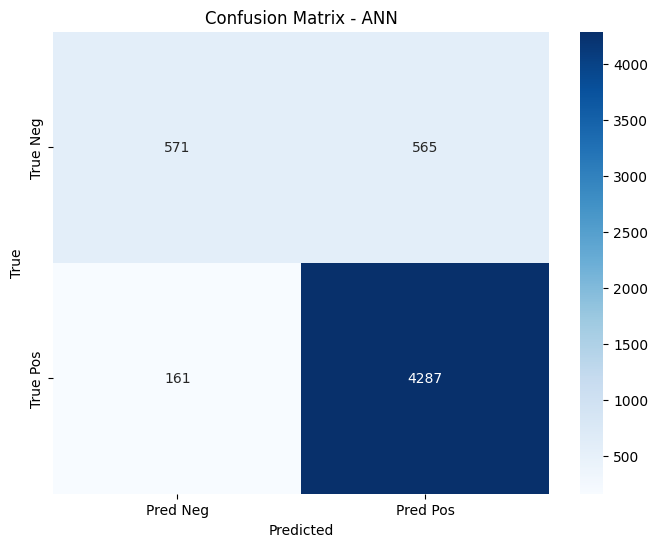


Total Correct: 4858 (87.00%)
------------------------------------------------------------
True Positives (TP): 4287 (76.77%)
True Negatives (TN): 571 (10.23%)

Total Errors: 726 (13.00%)
------------------------------------------------------------
False Positives (FP): 565 (10.12%)
False Negatives (FN): 161 (2.88%)
175/175 [==============================] - 0s 2ms/step


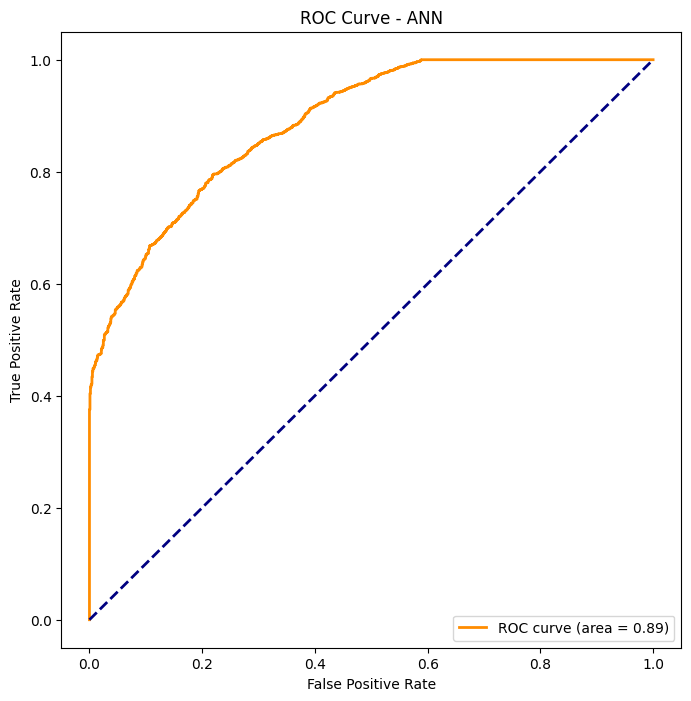

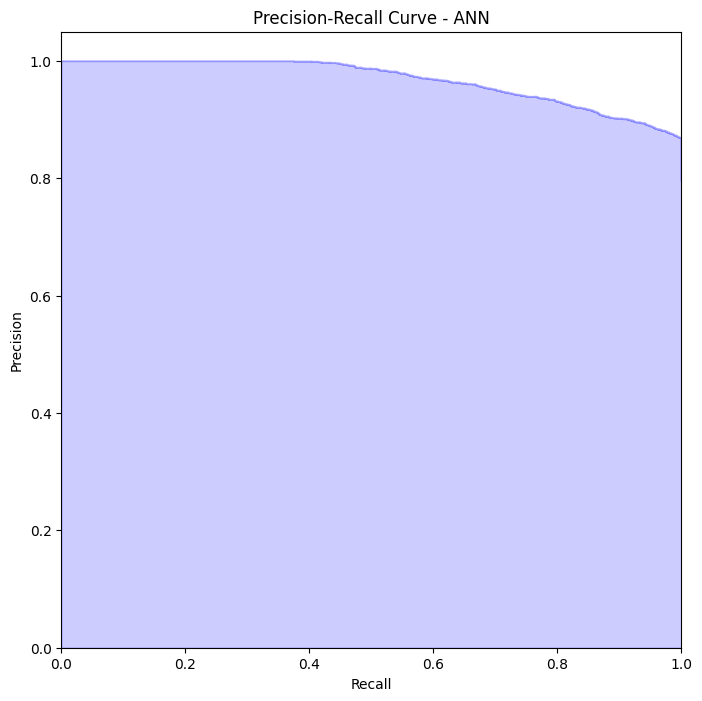

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score

# Function to create model
def build_model():
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Custom scorer function
def custom_scorer(y_true, y_pred):
    return accuracy_score(y_true, (y_pred > 0.6).astype(int))

# Custom Keras classifier
class MyKerasClassifierWithProba(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn=None, epochs=15, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return (self.model_.predict(X) > 0.6).astype(int)

    def predict_proba(self, X):
        return self.model_.predict(X)

# Assuming you have loaded your data into X and y
target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with an imputer, scaler, and classifier
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('keras', MyKerasClassifierWithProba(build_fn=build_model, epochs=10, batch_size=32, verbose=0))
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'keras__batch_size': [16, 32],
    'keras__epochs': [10, 20],
    'keras__verbose': [0, 1]  # Add any additional hyperparameters you want to tune
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring=make_scorer(custom_scorer))
grid_search_result = grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search_result.best_params_
print(f'Best Parameters: {best_params}')

# Evaluate the best model on the test set
best_model = grid_search_result.best_estimator_
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, (y_pred_test > 0.5).astype(int))
print(f'Accuracy on Test Set: {accuracy_test}')

# Obtain predictions from the model
threshold = 0.5  # Threshold to convert probabilities into classes
train_preds_ann = (best_model.predict(X_train) > threshold).astype(int)
test_preds_ann = (best_model.predict(X_test) > threshold).astype(int)

model_name = 'ANN'
print_score(y_train, train_preds_ann, model_name, train=True)
print_score(y_test, test_preds_ann, model_name, train=False)

# Call functions:
plot_confusion_matrix(best_model, X_test, y_test, model_name)
plot_roc_pr_curves(best_model, X_test, y_test, model_name)
save_score(y_train, train_preds_ann, model_name, train=True)
save_score(y_test, test_preds_ann, model_name, train=False)


In [15]:
# Guardar el modelo
import pickle

with open('finished_model.model_ANN', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['ANN'].best_estimator_, archivo_salida)

NameError: ignored